In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import MaxPool2D
from keras.layers.convolutional import Conv2D
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print("Training input data shape: " + str(X_train.shape))
print("Training target data shape: " + str(y_train.shape))

Training input data shape: (50000, 32, 32, 3)
Training target data shape: (50000, 1)


In [4]:
print("Testing input data shape: " + str(X_test.shape))
print("Testing target data shape: " + str(y_test.shape))

Testing input data shape: (10000, 32, 32, 3)
Testing target data shape: (10000, 1)


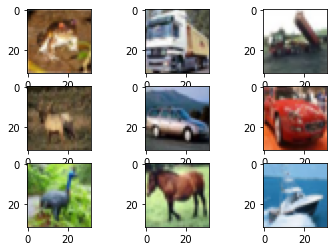

In [5]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i])
plt.show()

Example training images and their labels: [6]
Example training images and their labels: [9]
Example training images and their labels: [9]
Example training images and their labels: [4]
Example training images and their labels: [1]
Corresponding classes for the labels: frog
Corresponding classes for the labels: truck
Corresponding classes for the labels: truck
Corresponding classes for the labels: deer
Corresponding classes for the labels: automobile


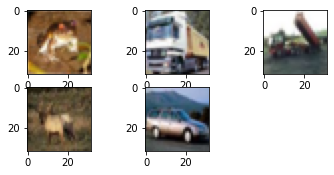

In [6]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for x in y_train[0:5]:
  print('Example training images and their labels: ' + str([x[0]]))
for x in y_train[0:5]:
  print('Corresponding classes for the labels: ' + str(classes[x[0]]))
for i in range(5):
    img = X_train[i]
    plt.subplot(330 + 1 + i)
    plt.imshow(img)

In [7]:
# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)
# Normalization of pixel values (to [0-1] range)
X_train=X_train/255.0
print("Initial X_train shape "+str(X_train.shape))
X_test=X_test/255.0
print("Initial X_test shape"+str(X_test.shape))
X_train = np.reshape(X_train,(50000,3072))
print("Final X_train shape "+str(X_train.shape))
X_test = np.reshape(X_test,(10000,3072))
print("Final X_test shape "+str(X_test.shape))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Initial X_train shape (50000, 32, 32, 3)
Initial X_test shape(10000, 32, 32, 3)
Final X_train shape (50000, 3072)
Final X_test shape (10000, 3072)


In [8]:
y_train=y_train.reshape(-1,)
y_test=y_test.reshape(-1,)

In [9]:
#The models we are going to use are: MLP,Random Forest, CNN 
#All models with and without pca

In [10]:
#MLP 
#Training a MLP classifier from keras with three hidden layers 
def MLP_train(X_train,y_train,X_test,y_test):
  
  #encoding basically one hot encoding
  y_train_encoded=[]
  for i in y_train:
    temp=[]
    for j in range(10):
      if(j!=i):
        temp.append(0)
      else:
        temp.append(1)
    y_train_encoded.append(temp)
  y_test_encoded=[]
  for i in y_test:
    temp=[]
    for j in range(10):
      if(j!=i):
        temp.append(0)
      else:
        temp.append(1)
    y_test_encoded.append(temp)

  #preparing the data for training and k-fold
  X_train=np.array(X_train)
  X_test=np.array(X_test)
  y_train_encoded=np.array(y_train_encoded)
  y_test_encoded=np.array(y_test_encoded)
  inputs = np.concatenate((X_train, X_test), axis=0)
  targets = np.concatenate((y_train_encoded, y_test_encoded), axis=0)

  #array for storing the acuracies and losses per fold
  accuracy_per_fold = []
  loss_per_fold = []
  #number of folds taken is 6
  number_folds=6

  kfold = KFold(n_splits=number_folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(inputs, targets):
    #defining the network
    mlp = Sequential()
    mlp.add(Dense(2050,input_dim=X_train.shape[1],activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(1030, activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(510,activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(10, activation='softmax'))

    #compiling the network
    mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    #fitting the network
    mlp.fit(inputs[train], targets[train], epochs=10,batch_size=64,verbose=2)

    #evaluating the network
    score = mlp.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {mlp.metrics_names[0]} of {score[0]}; {mlp.metrics_names[1]} of {score[1]*100}%')
    accuracy_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])
    fold_no = fold_no + 1
  
  #Average results
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')


In [11]:
#Random Forest
#defining the svm and training and cross validating it
def RF_train(X_train, y_train, X_test, y_test):
  #getting the inputs and targets for kfold
  inputs = np.concatenate((X_train, X_test), axis=0)
  targets = np.concatenate((y_train, y_test), axis=0)
  accuracy_per_fold = []
  number_folds=6

  #number of folds chosen is 6
  fold_no = 1
  kfold = KFold(n_splits=number_folds, shuffle=True)

  for train, test in kfold.split(inputs, targets):
    #declaring and training the model
    rf = RandomForestClassifier(n_estimators=300)
    rf.fit(inputs[train], targets[train])
    print(f'Accuracy for fold {fold_no}',rf.score(inputs[test],targets[test]))
    accuracy_per_fold.append(rf.score(inputs[test],targets[test]))
    fold_no=fold_no+1

  #average results
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} -  Accuracy: {accuracy_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
  print('------------------------------------------------------------------------')

In [12]:
#CNN
#Defining training and cross validating a cnn model
def CNN_train(X_train, y_train, X_test, y_test):

  #encoding basically one hot encoding 
  y_train_encoded=[]
  for i in y_train:
    temp=[]
    for j in range(10):
      if(j!=i):
        temp.append(0)
      else:
        temp.append(1)
    y_train_encoded.append(temp)
  y_test_encoded=[]
  for i in y_test:
    temp=[]
    for j in range(10):
      if(j!=i):
        temp.append(0)
      else:
        temp.append(1)
    y_test_encoded.append(temp) 


  #preparing the data for training and k-fold
  X_train=np.array(X_train)
  X_test=np.array(X_test)
  y_train_encoded=np.array(y_train_encoded)
  y_test_encoded=np.array(y_test_encoded)
  X_train=X_train.reshape(-1,32,32,3)
  X_test=X_test.reshape(-1,32,32,3)
  inputs = np.concatenate((X_train, X_test), axis=0)
  targets = np.concatenate((y_train_encoded, y_test_encoded), axis=0)

  #array for storing the acuracies and losses per fold
  acc_per_fold = []
  loss_per_fold = []

  #number of folds taken is 6
  num_folds=6

  kfold = KFold(n_splits=num_folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(inputs, targets):
    #defining the network
    cnn = Sequential()
    cnn.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32,32,3), activation='relu',))
    cnn.add(MaxPool2D(pool_size=(2, 2)))
    cnn.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu',))
    cnn.add(MaxPool2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(10, activation='softmax'))

    #compiling the network
    cnn.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    #fitting the network
    cnn.fit(inputs[train], targets[train], batch_size=128, epochs=20)

    #evaluating the network
    score = cnn.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {cnn.metrics_names[0]} of {score[0]}; {cnn.metrics_names[1]} of {score[1]*100}%')
    acc_per_fold.append(score[1] * 100)
    loss_per_fold.append(score[0])
    fold_no = fold_no + 1

  #Average results
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [13]:
#PCA
def get_PCA_data(X_train, X_test):
  pca = PCA()
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)
  return X_train_pca, X_test_pca

In [14]:
#Caling normally
#First MLP
MLP_train(X_train,y_train,X_test,y_test)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
782/782 - 61s - loss: 1.9768 - accuracy: 0.2786
Epoch 2/10
782/782 - 61s - loss: 1.8224 - accuracy: 0.3394
Epoch 3/10
782/782 - 58s - loss: 1.7579 - accuracy: 0.3632
Epoch 4/10
782/782 - 58s - loss: 1.7210 - accuracy: 0.3778
Epoch 5/10
782/782 - 59s - loss: 1.6939 - accuracy: 0.3903
Epoch 6/10
782/782 - 59s - loss: 1.6789 - accuracy: 0.3930
Epoch 7/10
782/782 - 62s - loss: 1.6594 - accuracy: 0.4002
Epoch 8/10
782/782 - 63s - loss: 1.6459 - accuracy: 0.4076
Epoch 9/10
782/782 - 60s - loss: 1.6280 - accuracy: 0.4137
Epoch 10/10
782/782 - 57s - loss: 1.6252 - accuracy: 0.4132
Score for fold 1: loss of 1.6008697748184204; accuracy of 42.260000109672546%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
782/782 - 61s - loss: 1.9825 - accuracy: 0.2814
Epoch 2/10
782/782 - 57s - loss: 1.8265 - accuracy: 0.3379
Epoch 3/10
782/782 

In [15]:
#Caling normally
#Second rf
RF_train(X_train,y_train,X_test,y_test)

Accuracy for fold 1 0.4821
Accuracy for fold 2 0.4818
Accuracy for fold 3 0.4821
Accuracy for fold 4 0.4813
Accuracy for fold 5 0.4794
Accuracy for fold 6 0.4847
------------------------------------------------------------------------
Score per fold
> Fold 1 -  Accuracy: 0.4821%
> Fold 2 -  Accuracy: 0.4818%
> Fold 3 -  Accuracy: 0.4821%
> Fold 4 -  Accuracy: 0.4813%
> Fold 5 -  Accuracy: 0.4794%
> Fold 6 -  Accuracy: 0.4847%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.4819 (+- 0.0015567059238447553)
------------------------------------------------------------------------


In [16]:
#Caling normally
#Third svm
CNN_train(X_train,y_train,X_test,y_test)

Epoch 1/20
391/391 [==============================] - 40s 97ms/step - loss: 2.1064 - accuracy: 0.2008
Epoch 2/20
391/391 [==============================] - 37s 95ms/step - loss: 1.6057 - accuracy: 0.4070
Epoch 3/20
391/391 [==============================] - 38s 96ms/step - loss: 1.4672 - accuracy: 0.4672
Epoch 4/20
391/391 [==============================] - 38s 96ms/step - loss: 1.3521 - accuracy: 0.5190
Epoch 5/20
391/391 [==============================] - 34s 88ms/step - loss: 1.2871 - accuracy: 0.5482
Epoch 6/20
391/391 [==============================] - 36s 93ms/step - loss: 1.2362 - accuracy: 0.5650
Epoch 7/20
391/391 [==============================] - 36s 91ms/step - loss: 1.1805 - accuracy: 0.5846
Epoch 8/20
391/391 [==============================] - 37s 94ms/step - loss: 1.1320 - accuracy: 0.6032
Epoch 9/20
391/391 [==============================] - 38s 98ms/step - loss: 1.1038 - accuracy: 0.6189
Epoch 10/20
391/391 [==============================] - 39s 99ms/step - loss: 1.071

391/391 [==============================] - 38s 97ms/step - loss: 0.8428 - accuracy: 0.7107
Epoch 19/20
391/391 [==============================] - 38s 98ms/step - loss: 0.8200 - accuracy: 0.7202
Epoch 20/20
391/391 [==============================] - 38s 98ms/step - loss: 0.8112 - accuracy: 0.7207
Score for fold 4: loss of 0.9206362366676331; accuracy of 68.73000264167786%
Epoch 1/20
391/391 [==============================] - 41s 101ms/step - loss: 2.0918 - accuracy: 0.2017
Epoch 2/20
391/391 [==============================] - 43s 110ms/step - loss: 1.5854 - accuracy: 0.4199
Epoch 3/20
391/391 [==============================] - 40s 102ms/step - loss: 1.4247 - accuracy: 0.4867
Epoch 4/20
391/391 [==============================] - 37s 96ms/step - loss: 1.3122 - accuracy: 0.5354
Epoch 5/20
391/391 [==============================] - 42s 107ms/step - loss: 1.2389 - accuracy: 0.5652
Epoch 6/20
391/391 [==============================] - 40s 103ms/step - loss: 1.1690 - accuracy: 0.5904
Epoch 7/2

In [17]:
#calling with pca
#First MLP
X_train_pca, X_test_pca=get_PCA_data(X_train,X_test)
MLP_train(X_train_pca,y_train,X_test_pca,y_test)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
782/782 - 31s - loss: 1.6112 - accuracy: 0.4279
Epoch 2/10
782/782 - 31s - loss: 1.3058 - accuracy: 0.5399
Epoch 3/10
782/782 - 32s - loss: 1.0903 - accuracy: 0.6134
Epoch 4/10
782/782 - 33s - loss: 0.9042 - accuracy: 0.6782
Epoch 5/10
782/782 - 34s - loss: 0.7309 - accuracy: 0.7420
Epoch 6/10
782/782 - 34s - loss: 0.5854 - accuracy: 0.7914
Epoch 7/10
782/782 - 33s - loss: 0.4804 - accuracy: 0.8308
Epoch 8/10
782/782 - 32s - loss: 0.3884 - accuracy: 0.8622
Epoch 9/10
782/782 - 33s - loss: 0.3387 - accuracy: 0.8823
Epoch 10/10
782/782 - 33s - loss: 0.2935 - accuracy: 0.8998
Score for fold 1: loss of 1.8563425540924072; accuracy of 55.19999861717224%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
782/782 - 34s - loss: 1.6094 - accuracy: 0.4291
Epoch 2/10
782/782 - 31s - loss: 1.3006 - accuracy: 0.5422
Epoch 3/10
782/782 -

In [18]:
#calling with pca
#Second rf
RF_train(X_train_pca,y_train,X_test_pca,y_test)

Accuracy for fold 1 0.4346
Accuracy for fold 2 0.44
Accuracy for fold 3 0.4384
Accuracy for fold 4 0.444
Accuracy for fold 5 0.4419
Accuracy for fold 6 0.4455
------------------------------------------------------------------------
Score per fold
> Fold 1 -  Accuracy: 0.4346%
> Fold 2 -  Accuracy: 0.44%
> Fold 3 -  Accuracy: 0.4384%
> Fold 4 -  Accuracy: 0.444%
> Fold 5 -  Accuracy: 0.4419%
> Fold 6 -  Accuracy: 0.4455%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.44073333333333337 (+- 0.0036137084676117594)
------------------------------------------------------------------------


In [20]:
#calling with pca
#Third CNN
CNN_train(X_train_pca,y_train,X_test_pca,y_test)

Epoch 1/20
391/391 [==============================] - 36s 90ms/step - loss: 2.1703 - accuracy: 0.1759
Epoch 2/20
391/391 [==============================] - 35s 90ms/step - loss: 1.7817 - accuracy: 0.3378
Epoch 3/20
391/391 [==============================] - 35s 90ms/step - loss: 1.6657 - accuracy: 0.3931
Epoch 4/20
391/391 [==============================] - 36s 91ms/step - loss: 1.6097 - accuracy: 0.4147
Epoch 5/20
391/391 [==============================] - 36s 91ms/step - loss: 1.5632 - accuracy: 0.4316
Epoch 6/20
391/391 [==============================] - 35s 91ms/step - loss: 1.5296 - accuracy: 0.4431
Epoch 7/20
391/391 [==============================] - 35s 91ms/step - loss: 1.5118 - accuracy: 0.4578
Epoch 8/20
391/391 [==============================] - 35s 90ms/step - loss: 1.4719 - accuracy: 0.4674
Epoch 9/20
391/391 [==============================] - 35s 89ms/step - loss: 1.4571 - accuracy: 0.4792
Epoch 10/20
391/391 [==============================] - 41s 104ms/step - loss: 1.43